## Importing Required Libraries

In [1]:
# Installing Compatible Gensim and Numpy (Numpy 1.25.2 and gensim 4.3.3 seems right lower than 1.21.0 do not have numpy.strings function)
!pip uninstall -y numpy gensim
!pip install "numpy<1.26.0,>=1.21.0" gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 51.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
langchain 0.3.19 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 1.25.2 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.


In [2]:
import numpy as np
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Load the Text8 Dataset
The **Text8 dataset** is a large-scale dataset extracted from Wikipedia, often used for training word embeddings.  
It consists of approximately 17 million words in a single text file, formatted as a sequence of words without punctuation.

In this step, you will:
1. **Download the Text8 dataset** using Gensim's downloader.
2. **Convert it to a list named text8_corpus** to use it for training.

In [20]:
# For loading dataset it's enough to use load function and why should I convert it to list. it could be trained just like this in word2vec model :|||

text8_corpus = api.load('text8')

In [21]:
len(list(text8_corpus))

1701

## Train a Word2Vec Model in CBOW Mode

In this step, you will initialize a Word2Vec model and train it using a specific architecture.  
The model will learn word representations based on a **context-predicting approach**, where surrounding words help predict the target word.  

Consider the impact of different parameters such as:
- The size of the word representations(e.g., 300 dimensions).
- The number of neighboring words considered(e.g., 5 neighbors).
- The minimum occurrences required for a word to be included in the vocabulary(e.g., 5 occurrences).
- The number of CPU cores used for training(e.g., 4 cores).

Run the code below to train the model for **one epoch**.


In [7]:
# For creating a model we should use this class and then use train for train it.
# Sentences means that we give our model our corpus, other parts are defined in upper markdown, sg means the skip-gram and 0 means False and show that we do not use skip-gram model.
model = Word2Vec(sentences = text8_corpus, vector_size = 300, window = 5, min_count = 5, workers = 4, sg = 0)


In [8]:
model.train(text8_corpus, total_examples = model.corpus_count, epochs = 1)

(12506674, 17005207)

## Example Words
We select a few words of interest.

In [9]:
words = ["king", "queen", "man", "woman", "car", "bus"]

## Compare Word Similarities

After training the Word2Vec model, we can analyze how well it captures relationships between words.  
In this step, we:
- Find the **top 5 most similar words** for each based on cosine similarity.
- Display the results in a structured format.

Words with high similarity scores are expected to have similar meanings or occur in similar contexts.  
If a word is **not found in the vocabulary**, it means it didn’t meet the minimum occurrence threshold during training.


In [10]:
for word in words:
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=5) # This here return 5 most similars words in our word vector similar to our vector based on CBOW
        display(Markdown(f"**{word}:**"))
        for w, score in similar_words:
            display(Markdown(f"- {w}: {score:.4f}"))
    else:
        display(Markdown(f"{word} not in vocabulary."))

**king:**

- kings: 0.6271

- prince: 0.6091

- queen: 0.5911

- vii: 0.5823

- throne: 0.5762

**queen:**

- princess: 0.6838

- elizabeth: 0.6818

- consort: 0.6036

- prince: 0.5991

- king: 0.5911

**man:**

- woman: 0.6039

- girl: 0.5409

- creature: 0.4915

- gentleman: 0.4853

- boy: 0.4842

**woman:**

- girl: 0.6850

- child: 0.6773

- lady: 0.6047

- man: 0.6039

- lover: 0.6029

**car:**

- driver: 0.7428

- cars: 0.6929

- motorcycle: 0.6874

- taxi: 0.6416

- truck: 0.6283

**bus:**

- tram: 0.7711

- buses: 0.7596

- commuter: 0.7508

- trains: 0.7302

- intercity: 0.7283

## Visualizing Word Embeddings

Word embeddings are high-dimensional vectors, making them difficult to interpret directly.  
To visualize them, we use **Principal Component Analysis (PCA)** to reduce their dimensionality from 300 to 2.

### Steps:
1. Extract word vectors for selected words.
2. Apply **PCA** to reduce dimensionality from 300 to 2.
3. Plot the words in a 2D space.

Words that appear in similar contexts should be **closer together** in the plot.


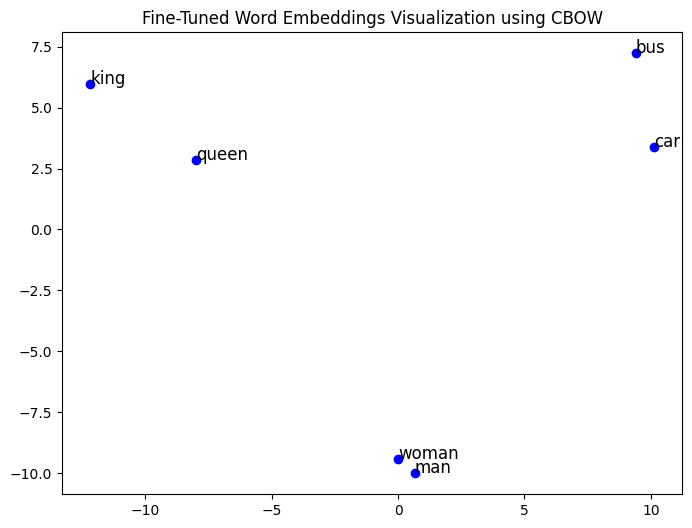

In [11]:
# Here we define our word vectors and use pca to reduce the dimensions to 2 principle components to visualize vectors better
vectors = np.array([model.wv[word] for word in words if word in model.wv])
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)
plt.figure(figsize=(8,6))
plt.scatter(result[:, 0], result[:, 1], color='blue')
for i, word in enumerate(words):
    if word in model.wv:
        plt.annotate(word, (result[i, 0], result[i, 1]), fontsize=12)
plt.title("Fine-Tuned Word Embeddings Visualization using CBOW")
plt.show()

## Training Word2Vec with Skip-gram

Now, we will train another Word2Vec model using a different architecture called **Skip-gram**.  
Unlike the previous CBOW approach, Skip-gram learns to predict **context words** given a target word, making it more effective for learning representations of rare words.

Repeat the previous steps:
1. Initialize a new Word2Vec model with a different training mode.
2. Train it using the **Text8 dataset** for one epoch.


In [12]:
# Just like the CBOW just the sg would be 1 because of using skip-gram model
model_skip_gram = Word2Vec(sentences = text8_corpus, vector_size = 300, window = 5, min_count =5, workers = 4, sg = 1)

model_skip_gram.train(text8_corpus, total_examples = model_skip_gram.corpus_count, epochs = 1)

(12506568, 17005207)

## Compare Word Similarities (Skip-gram)
Now, we repeat the similarity comparison, but this time using the **Skip-gram** model.

- Skip-gram focuses on predicting surrounding words given a target word.
- It is better suited for smaller datasets and learns high-quality embeddings, especially for infrequent words.
- Here, we retrieve and display the most similar words for a given set of words.


In [22]:
for word in words:
    if word in model_skip_gram.wv:
        similar_words = model_skip_gram.wv.most_similar(word, topn = 5) # Just like CBOW return top 5 similar words using skip-gram this time
        display(Markdown(f"**{word}:**"))
        for w, score in similar_words:
            display(Markdown(f"- {w}: {score:.4f}"))
    else:
        display(Markdown(f"{word} not in vocabulary."))

**king:**

- canute: 0.5920

- queen: 0.5745

- lulach: 0.5680

- sweyn: 0.5671

- haakon: 0.5636

**queen:**

- elizabeth: 0.6499

- consort: 0.5836

- margrethe: 0.5797

- king: 0.5745

- monarch: 0.5705

**man:**

- woman: 0.5123

- shaves: 0.5074

- girl: 0.4939

- awakens: 0.4888

- loner: 0.4854

**woman:**

- girl: 0.5744

- prostitute: 0.5395

- spinster: 0.5172

- sired: 0.5136

- man: 0.5123

**car:**

- cars: 0.6587

- driver: 0.6223

- truck: 0.5681

- automobile: 0.5555

- racer: 0.5519

**bus:**

- buses: 0.7258

- tram: 0.6434

- trolleybus: 0.6268

- intercity: 0.6263

- minibus: 0.6231

## Visualizing Word Embeddings (Skip-gram)
Now, we visualize the word embeddings obtained from the **Skip-gram** model.

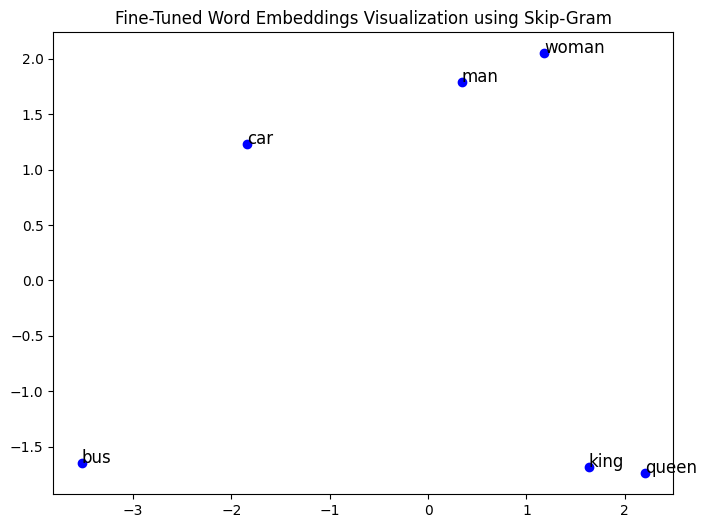

In [16]:
# Using PCA to reduce dimensions and visualize data better
vectors = np.array([model_skip_gram.wv[word] for word in words if word in model_skip_gram.wv])
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)
plt.figure(figsize=(8,6))
plt.scatter(result[:, 0], result[:, 1], color='blue')
for i, word in enumerate(words):
    if word in model.wv:
        plt.annotate(word, (result[i, 0], result[i, 1]), fontsize=12)
plt.title("Fine-Tuned Word Embeddings Visualization using Skip-Gram")
plt.show()

# Doc
## CBOW Model
https://www.geeksforgeeks.org/continuous-bag-of-words-cbow-in-nlp/
<br> As we can see king and queen are near together in our visualzation and also in the similar words we can see them both representing in each other similar words. Also prince is in both of them and all of these show that these two words are similar.
<br> Man and woman are very close to each other and their similar words are close to each other too.
<br> In the end the bus and car are close to each other too that means their similar words should be close to each other too and we can saw that even when there is no same similar words but words are too close to each other.
<br><br>
## Skip-Gram Model
https://spotintelligence.com/2023/07/11/skip-gram-models-explained-how-to-create-embeddings-in-word2vec/#:~:text=Skip%2Dgram%20is%20a%20popular,the%20context%20of%20word2vec%20models.
<br>
In skip-gram some places are changed and also we can see that queen and king are closer but car and bus got further from each other and their similar words are a little further from CBOW. Also man and woman are a little further than CBOW but their similar words still are close to each other.